## Data Preprocessing

In [1]:
from statsmodels.tsa.stattools import coint
from tempdisagg import TempDisaggModel
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('Data/Macro.csv')
data['Exports_numeric'] = pd.to_numeric(data['Exports'], errors='coerce')
data['Imports_numeric'] = pd.to_numeric(data['Imports'], errors='coerce')
data['USDPHP_numeric'] = pd.to_numeric(data['USDPHP'], errors='coerce')

data['Monthly_Trade_PHP'] = (
    data['Exports_numeric'] + data['Imports_numeric']
) * data['USDPHP_numeric']

# Create quarterly trade by summing 3 months
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + 
                             data['Month'].astype(str) + '-01')
data.set_index('Date', inplace=True)

# Resample to quarterly sum
quarterly_trade = data['Monthly_Trade_PHP'].resample('QE').sum()

# Get quarterly GDP (remove NaNs)
quarterly_gdp = data['Nominal GDP'].resample('QE').mean().dropna()

# Align both series on common dates
start, end = "1991-01-01", "2004-12-31"

gdp_series = quarterly_gdp.loc[start:end]
trade_series = quarterly_trade.loc[start:end]

# Test for cointegration
coint(gdp_series, trade_series, autolag='AIC')


(np.float64(-2.3757208699955488),
 np.float64(0.3364386725432962),
 array([-4.10664876, -3.44947826, -3.1224619 ]))

In [52]:
from disaggregation import main
subset = main() 
subset.head()

Disaggregated CSV exists. Loading...


,Unnamed: 3,Inflation,Population,GDP,Imports,Exports,Agriculture,Industry,Services,USDPHP,Nominal GDP,TotalTrade,TotalTrade_PHPMN,NominalGDP_disagg,Pop_disagg
0,1/1/1992,10.9,NaN,NaN,1037.69,662.37,NaN,NaN,NaN,26.5446,NaN,1700.06,45127.41268,136347.8527,63004203.31
1,2/1/1992,9.1,NaN,NaN,1032.51,714.90,NaN,NaN,NaN,26.1580,NaN,1747.41,45708.75078,137765.5289,62965193.58
2,3/1/1992,8.7,NaN,1244652.42,1164.81,898.46,18.11,32.58,49.3,25.8102,362800.0,2063.27,53253.41135,128415.5503,62929730.18
3,4/1/1992,8.4,NaN,NaN,1196.81,666.45,NaN,NaN,NaN,25.6672,NaN,1863.26,47824.66707,120089.5621,62897813.13
4,5/1/1992,8.9,NaN,NaN,1186.29,811.71,NaN,NaN,NaN,26.1496,NaN,1998.00,52246.90080,124258.7011,62869442.41


In [53]:
!python disaggregation.py

Disaggregated CSV exists. Loading...


## Model Building

for testing/reference only

actual code already in separate scripts, go straight to tuning to use

In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.model_selection import TimeSeriesSplit

import random

import os
import json


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.X) - self.seq_len 
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len])

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.2):
        super(GRUModel, self).__init__()
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0  # Changed from dropout to 0
        )
        
        # Add manual dropout layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.dropout(out)  # Apply dropout manually here
        out = self.fc(out)
        return out

In [4]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    def forward(self, predictions, targets):       
        return torch.sqrt(self.mse(predictions, targets) + 1e-6)
        
class MAPELoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MAPELoss, self).__init__()
        self.epsilon = epsilon  # Small constant to prevent division by zero

    def forward(self, output, target):
        return torch.mean(torch.abs((target - output) / (target + self.epsilon)))*100

In [5]:
class Arguments:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [6]:
def set_seed(seed=None):
    if seed is None:
        seed = 1
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Remove CUDA-specific settings for Mac
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    
    # MPS doesn't need special deterministic settings
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
def split_data(X, use_val=True):
    if use_val:
        train_size = int(0.6 * len(X))
        val_size = int(0.2 * len(X))

        train = X[:train_size]
        val = X[train_size:train_size + val_size]
        test = X[train_size + val_size:]

        return train, val, test

In [8]:
from sklearn.preprocessing import MinMaxScaler
import pickle

def transform_data(data, save_path="Transforms/scaler.pkl"):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    with open(save_path, "wb") as f:
        pickle.dump(scaler, f)
    
    return data_scaled

def inverse_transform(data, load_path="Transforms/scaler.pkl"):
    with open(load_path, "rb") as f:
        scaler = pickle.load(f)
    return scaler.inverse_transform(data)

In [9]:
def train_model(model, dataloader, device, optimizer, criterion):

    model.train()
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    return total_loss / total_samples if total_samples > 0 else 0.0

@torch.no_grad()
def evaluate(model, dataloader, device, criterion, args):

    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        loss = criterion(outputs, targets)

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        all_preds.append(outputs.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0

    return avg_loss, all_preds

In [ ]:
def run(model, train_loader, val_loader, test_loader, args, fold=None):
    
    set_seed(args.seed if hasattr(args, 'seed') else 1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        factor=args.factor, 
        patience=args.patience
    )
    
    train_losses = []
    val_losses = []

    for e in range(args.epoch):
        train_loss = train_model(model, train_loader, args.device, optimizer, args.train_criterion)
        val_loss, _ = evaluate(model, val_loader, args.device, args.train_criterion, args)
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (e + 1) % 100 == 0 or e == 0:
            fold_prefix = f"Fold {fold} - " if fold is not None else ""
            print(f"{fold_prefix}Epoch {e+1}/{args.epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    _, test_preds = evaluate(model, test_loader, args.device, args.test_criterion, args)

    # Inverse transform 
    if fold is not None:
        scaler_name = f"Transforms/labels_scaled{fold}"
    else:
        scaler_name =f"Transforms/labels_scaled"
    
    inversed_test_preds = inverse_transform(test_preds, scaler_name)
    
    # Get corresponding actual labels from test_loader 
    actual_labels = []
    for _, targets in test_loader:
        actual_labels.append(targets)
    actual_labels = torch.cat(actual_labels, dim=0).cpu().numpy()
    
    # Inverse transform actual labels 
    inversed_actual = inverse_transform(actual_labels, scaler_name)
    
    # Calculate test loss
    test_loss = args.test_criterion(
        torch.tensor(inversed_test_preds), 
        torch.tensor(inversed_actual)
    )
    
    return test_loss, inversed_test_preds, train_losses, val_losses

In [ ]:
def crossval(data, labels, test_data, test_labels, args, n_splits=5):
        
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        print(f"\n{'='*50}")
        print(f"Fold {fold + 1}/{n_splits}")
        print(f"{'='*50}")
        
        # Split data for this fold
        train_data_fold = data[train_idx]
        train_labels_fold = labels[train_idx]
        val_data_fold = data[val_idx]
        val_labels_fold = labels[val_idx]
        
        # Scale data
        set_seed(1)
        train_data_scaled = transform_data(train_data_fold, f"Transforms/train_scaled_{fold}")
        train_labels_scaled = transform_data(train_labels_fold, f"Transforms/labels_scaled{fold}")
        val_data_scaled = transform_data(val_data_fold, f"Transforms/train_scaled_{fold}")
        val_labels_scaled = transform_data(val_labels_fold, f"Transforms/labels_scaled{fold}")
        test_data_scaled = transform_data(test_data, f"Transforms/train_scaled_{fold}")
        test_labels_scaled = transform_data(test_labels, f"Transforms/labels_scaled{fold}")
        
        input_size = train_data_scaled.shape[1]
        output_size = train_labels_scaled.shape[1]
        
        # Create datasets
        train_dataset = TimeSeriesDataset(train_data_scaled, train_labels_scaled, seq_len=args.seq_len)
        val_dataset = TimeSeriesDataset(val_data_scaled, val_labels_scaled, seq_len=args.seq_len)
        test_dataset = TimeSeriesDataset(test_data_scaled, test_labels_scaled, seq_len=args.seq_len)
        
        # Create loaders
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
        
        # Create fresh model for this fold
        set_seed(1)
        model = GRUModel(
            input_size=input_size,
            hidden_size=args.hidden_size,
            output_size=output_size,
            num_layers=args.num_layers,
            dropout=args.dropout
        ).to(args.device)
        
        # Pass fold number to run function
        test_loss, test_preds, train_losses, val_losses = run(
            model, 
            train_loader, 
            val_loader, 
            test_loader, 
            args,
            fold=fold  # Pass fold number
        )
        
        # Store results
        fold_results.append({
            'fold': fold + 1,
            'test_loss': test_loss.item() if torch.is_tensor(test_loss) else test_loss,
            'test_preds': test_preds,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_size': len(train_idx),
            'val_size': len(val_idx)
        })
        
        print(f"Fold {fold + 1} Test Loss: {test_loss:.4f}")
    
    # Summary statistics
    test_losses = [r['test_loss'] for r in fold_results]
    print(f"\n{'='*50}")
    print(f"Cross-Validation Results:")
    print(f"{'='*50}")
    print(f"Mean Test Loss: {np.mean(test_losses):.4f} (+/- {np.std(test_losses):.4f})")
    print(f"Min Test Loss: {np.min(test_losses):.4f}")
    print(f"Max Test Loss: {np.max(test_losses):.4f}")
    
    return fold_results

In [12]:
def load_dataset(args):
    """Load and prepare all datasets"""
    
    # Load raw data files
    btr_data = pd.read_csv("Data/cordata.csv")
    btr_data = btr_data.set_index("Date")

    macro_data = pd.read_csv("Data/disaggregated.csv")
    macro_data = macro_data.rename(columns={'Unnamed: 3': 'Date'}).set_index('Date')
    macro_data = macro_data[['TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg']]

    dummy = pd.read_csv("Data/dummy.csv").fillna(0)
    dummy = dummy.set_index("Date")

    # Convert to datetime
    btr_data.index = pd.to_datetime(btr_data.index)
    macro_data.index = pd.to_datetime(macro_data.index)
    dummy.index = pd.to_datetime(dummy.index)

    # Keep Jan 1992 onwards
    start = "1992-01-01"
    btr_data = btr_data.loc[start:]
    macro_data = macro_data.loc[start:]
    dummy = dummy.loc[start:]

    # Join data
    df = btr_data.join(macro_data, how="inner").join(dummy, how="inner")

    # Create X and y
    X = pd.concat(
        [btr_data[['BIR', 'BOC', 'Other Offices']], macro_data, dummy],
        axis=1
    ).values.copy()
    y = df[['BIR', 'BOC', 'Other Offices']].values.copy()

    # Split into train/val/test
    train_data, val_data, test_data = split_data(X)
    train_labels, val_labels, test_labels = split_data(y)
    
    # Combine train + val for cross-validation
    cv_data = np.concatenate([train_data, val_data], axis=0)
    cv_labels = np.concatenate([train_labels, val_labels], axis=0)

    # Return everything needed
    return {
        'cv_data': cv_data,
        'cv_labels': cv_labels,
        'test_data': test_data,
        'test_labels': test_labels,
        'input_size': cv_data.shape[1],
        'output_size': cv_labels.shape[1]
    }

In [ ]:
with open("config.json", "r") as f:
    config = json.load(f)

args = Arguments(**config)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device

# Add criterions
args.train_criterion = nn.MSELoss()
args.test_criterion = MAPELoss()

# Load dataset
dataset = load_dataset(None)

# Add dataset to args
args.cv_data = dataset['cv_data']
args.cv_labels = dataset['cv_labels']
args.test_data = dataset['test_data']
args.test_labels = dataset['test_labels']
args.input_size = dataset['input_size']
args.output_size = dataset['output_size']

# Set seed
set_seed(args.seed)

# Run cross-validation

fold_results = crossval(
    data=args.cv_data,
    labels=args.cv_labels,
    args=args,
    n_splits=5
)

# Summary
test_losses = [r['test_loss'] for r in fold_results]
print(f"\n{'='*50}")
print(f"Cross-Validation Results:")
print(f"{'='*50}")
print(f"Mean Test Loss: {np.mean(test_losses):.4f} (+/- {np.std(test_losses):.4f})")
print(f"Min Test Loss: {np.min(test_losses):.4f}")
print(f"Max Test Loss: {np.max(test_losses):.4f}")

Running 5-fold cross-validation...

Fold 1/5
Fold 0 - Epoch 1/200 - Train Loss: 0.2552, Val Loss: 0.0550
Fold 0 - Epoch 100/200 - Train Loss: 0.0365, Val Loss: 0.0585
Fold 0 - Epoch 200/200 - Train Loss: 0.0389, Val Loss: 0.0585
Fold 1 Test Loss: 38.2783

Fold 2/5
Fold 1 - Epoch 1/200 - Train Loss: 0.0882, Val Loss: 0.0536
Fold 1 - Epoch 100/200 - Train Loss: 0.0254, Val Loss: 0.0627
Fold 1 - Epoch 200/200 - Train Loss: 0.0249, Val Loss: 0.0627
Fold 2 Test Loss: 23.8141

Fold 3/5
Fold 2 - Epoch 1/200 - Train Loss: 0.0541, Val Loss: 0.0799
Fold 2 - Epoch 100/200 - Train Loss: 0.0189, Val Loss: 0.0467
Fold 2 - Epoch 200/200 - Train Loss: 0.0149, Val Loss: 0.0420
Fold 3 Test Loss: 24.9076

Fold 4/5
Fold 3 - Epoch 1/200 - Train Loss: 0.0327, Val Loss: 0.1517
Fold 3 - Epoch 100/200 - Train Loss: 0.0078, Val Loss: 0.0522
Fold 3 - Epoch 200/200 - Train Loss: 0.0081, Val Loss: 0.0522
Fold 4 Test Loss: 22.8305

Fold 5/5
Fold 4 - Epoch 1/200 - Train Loss: 0.0339, Val Loss: 0.1590
Fold 4 - Epoch 

In [ ]:
with open("config.json", "r") as f:
    config = json.load(f)

args = Arguments(
    **config, 
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device

# Load dataset
dataset = load_dataset(None)

set_seed(1)

# Split cv_data into train/val one more time
train_size = int(0.85 * len(dataset['cv_data']))
final_train_data = dataset['cv_data'][:train_size]
final_train_labels = dataset['cv_labels'][:train_size]
final_val_data = dataset['cv_data'][train_size:]
final_val_labels = dataset['cv_labels'][train_size:]

# Scale data
final_train_scaled = transform_data(final_train_data, "Transforms/final_train_scaled")
final_train_labels_scaled = transform_data(final_train_labels, "Transforms/final_labels_scaled")
final_val_scaled = transform_data(final_val_data, "Transforms/final_train_scaled")
final_val_labels_scaled = transform_data(final_val_labels, "Transforms/final_labels_scaled")
final_test_scaled = transform_data(dataset['test_data'], "Transforms/final_train_scaled")
final_test_labels_scaled = transform_data(dataset['test_labels'], "Transforms/final_labels_scaled")

# Create datasets
train_dataset = TimeSeriesDataset(final_train_scaled, final_train_labels_scaled, seq_len=args.seq_len)
val_dataset = TimeSeriesDataset(final_val_scaled, final_val_labels_scaled, seq_len=args.seq_len)
test_dataset = TimeSeriesDataset(final_test_scaled, final_test_labels_scaled, seq_len=args.seq_len)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

set_seed(1)
final_model = GRUModel(
    input_size=dataset['input_size'],
    hidden_size=args.hidden_size,
    output_size=dataset['output_size'],
    num_layers=args.num_layers,
    dropout=args.dropout
).to(device)

args.train_criterion = nn.MSELoss()
args.test_criterion = MAPELoss()

# Train and evaluate
test_loss, test_preds, train_losses, val_losses = run(
    final_model,
    train_loader,
    val_loader,
    test_loader,
    args,
    fold=None  # Not cross-validation
)

print(f"\n{'='*50}")
print(f"Final Model Results:")
print(f"{'='*50}")
print(f"Final Test Loss (MAPE): {test_loss:.4f}%")

## Tuning

In [1]:
import os
os.environ['RAY_AIR_NEW_OUTPUT'] = '0' 

from ray import tune
from ray.tune import RunConfig
from ray.tune import Tuner
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune import CLIReporter

import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import train as tr
from model import GRUModel
from data import transform_data, TimeSeriesDataset, inverse_transform
from tuning import ray_train
import utils
import sarima as sm

import ray

from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
ray.shutdown()
ray.init(
    num_cpus=16,
    num_gpus=1,
    dashboard_host="0.0.0.0",  # Make dashboard accessible
    include_dashboard=True,     # Explicitly enable dashboard
    ignore_reinit_error=True
)

2026-02-21 23:27:51,435	INFO worker.py:1998 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
c:\Anaconda\envs\capsenv\Lib\site-packages\ray\_private\worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


Python version:,3.12.12
Ray version:,2.53.0
Dashboard:,http://127.0.0.1:8265


Run tuning

In [ ]:
TRAIN_LOSS = "mse"
trials     = 200

reporter = CLIReporter(
    metric="loss", mode="min",
    metric_columns=["loss", "std"],
    max_progress_rows=15,
    print_intermediate_tables=True,
    max_report_frequency=30,
    sort_by_metric=True
)

def trial_dirname_creator(trial):
    return f"trial_{trial.trial_id}"

# ── Label & Feature Config ─────────────────────────────────────────────────────
LABEL_COLS = ['Tax Revenues',"BIR", "BOC", "Other Offices", 'Non-tax Revenues', 'Expenditures']

FEATURE_CONFIG = {
    "features":     ['Tax Revenues',"BIR", "BOC", "Other Offices", "Non-tax Revenues", "Expenditures",
                     "TotalTrade_PHPMN", "NominalGDP_disagg", "Pop_disagg", "USDPHP"],
    "dummy_vars":   ["COVID-19", "TRAIN", "CREATE", "FIST", "BIR_COMM"],
    "use_seasonal": True,
    "lag_periods":  [1, 3, 6, 12],
    "use_lags":     True,
}

BASE_SEARCH_SPACE = {
    "hidden_size":      tune.choice([32, 48, 64, 96, 128]),
    "num_layers":       tune.choice([1, 2, 3]),
    "dropout":          tune.uniform(0.2, 0.4),
    "use_attention":    tune.choice([True,False]),
    "use_branches":     tune.choice([False]),
    "linear_residual":     tune.choice([True,False]),
    "lr":               tune.loguniform(1e-4, 5e-2),
    "wd":               tune.loguniform(1e-5, 1e-3),
    "factor":           tune.uniform(0.3, 0.5),
    "patience":         tune.choice([3, 5]),
    "batch_size":       tune.choice([16, 32]),
    "seq_len":          tune.choice([3, 6, 12, 24]),
    "l1_lambda":        tune.loguniform(1e-4, 1e-2),
    "train_loss_name":  TRAIN_LOSS,
    "n_splits": 3
}
START_DATES = ["1992-01-01", "2000-01-01", "2007-01-01"]

# ── Main Loop — 
all_results = {}

for start_date in START_DATES:
    all_results[start_date] = {}
    
    for label in LABEL_COLS:
        label_slug = label.replace(' ', '_')
        exp_name   = f"{label_slug}_{start_date[:4]}"

        print(f"\n{'='*60}")
        print(f"  TUNING: {label} | Start: {start_date}")
        print(f"{'='*60}")

        search_space = {
            **BASE_SEARCH_SPACE,
            **FEATURE_CONFIG,
            "labels":          [label],
            "experiment_name": exp_name,
            "start_date":      start_date,
        }

        scheduler  = ASHAScheduler(metric="loss", mode="min", max_t=50, grace_period=10, reduction_factor=2)
        search_alg = OptunaSearch(metric="loss", mode="min")

        resources = {"cpu": 4}
        if torch.cuda.is_available():
            resources["gpu"] = 0.25

        tuner = Tuner(
            tune.with_resources(ray_train, resources=resources),
            tune_config=tune.TuneConfig(
                search_alg=search_alg,
                scheduler=scheduler,
                num_samples=trials,
                trial_dirname_creator=trial_dirname_creator,
                max_concurrent_trials=4,
            ),
            run_config=RunConfig(
                name=f"gru_{exp_name}",
                storage_path=os.path.abspath("ray_results"),
                verbose=1,
                progress_reporter=reporter,
            ),
            param_space=search_space,
        )

        results      = tuner.fit()
        best_result  = results.get_best_result(metric="loss", mode="min")
        best_config  = best_result.config
        best_metrics = best_result.metrics

        # Save config
        exp_folder = f"configs/{exp_name}"
        os.makedirs(exp_folder, exist_ok=True)

        with open(f"{exp_folder}/best_config.json", "w") as f:
            json.dump(best_config, f, indent=4)

        with open(f"{exp_folder}/metadata.json", "w") as f:
            json.dump({
                "label":      label,
                "start_date": start_date,
                "best_loss":  best_metrics["loss"],
                "best_std":   best_metrics.get("std", None),
                "num_trials": len(results),
                "timestamp":  pd.Timestamp.now().isoformat(),
            }, f, indent=4)

        all_results[start_date][label] = {
            "best_loss": best_metrics["loss"],
            "best_std":  best_metrics.get("std", None),
        }

        print(f"\n✓ {label} ({start_date[:4]}) — Best CV MAPE: {best_metrics['loss']:.4f}%")

# ── Summary ───────────────────────────────────────────────
print(f"\n{'='*60}\nTUNING SUMMARY\n{'='*60}")
rows = [
    {
        "Start": sd[:4],
        "Label": label,
        "Best MAPE": f"{info['best_loss']:.4f}",
        "Std": f"{info['best_std']:.4f}" if info["best_std"] else "—"
    }
    for sd, labels in all_results.items()
    for label, info in labels.items()
]
print(pd.DataFrame(rows).to_string(index=False))

[I 2026-02-21 23:27:54,714] A new study created in memory with name: optuna



  TUNING: Tax Revenues | Start: 1992-01-01
== Status ==
Current time: 2026-02-21 23:27:54 (running for 00:00:00.14)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 4.0/16 CPUs, 0.25/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOM~1/AppData/Local/Temp/ray/session_2026-02-21_23-27-46_350773_17516/artifacts/2026-02-21_23-27-54/gru_Tax_Revenues_1992/driver_artifacts
Number of trials: 1/200 (1 PENDING)
+--------------------+----------+-------+--------------+-----------+----------+---------------+-------------+-------------------+------------+--------------+------------+-----------+-----------------+----------------+------------+
| Trial name         | status   | loc   |   batch_size |   dropout |   factor |   hidden_size |   l1_lambda | linear_residual   |         lr |   num_layers |   patience |   seq_len | use_attention   | use_branches   |         wd |
|--------------------+----------+-----

Run best config

In [4]:
# ============================================================
# FINAL MODEL TRAINING
# ============================================================

LABEL_COLS = ['Tax Revenues', 'Non-tax Revenues', 'Expenditures']

FEATURE_CONFIG = {
    "features":    ['Tax Revenues', "BIR", "BOC", "Other Offices", "Non-tax Revenues", "Expenditures",
                    "TotalTrade_PHPMN", "NominalGDP_disagg", "Pop_disagg", "USDPHP"],
    "dummy_vars":  ["COVID-19", "TRAIN", "CREATE", "FIST", "BIR_COMM"],
    "use_seasonal": False,
    "lag_periods":  [1, 3, 6, 12],
    "use_lags":     True,
}

final_results = {}

for label in LABEL_COLS:
    label_slug     = label.replace(' ', '_')
    results_folder = f"results/{label_slug}"
    os.makedirs(results_folder, exist_ok=True)

    print(f"\n{'='*60}\n  FINAL TRAINING: {label}\n{'='*60}")

    with open(f"configs/{label_slug}/best_config.json") as f:
        best_config = json.load(f)

    arch_keys  = ['hidden_size', 'num_layers', 'dropout', 'use_attention', 'use_branches',
                  'use_se', 'lr', 'wd', 'factor', 'patience', 'batch_size', 'seq_len',
                  'l1_lambda', 'train_loss_name']
    arch_config = {k: best_config[k] for k in arch_keys if k in best_config}

    args = tr.Arguments(
        **arch_config,
        **FEATURE_CONFIG,
        labels=[label],
        seed=1,
        epoch=300,
        experiment_name=label_slug,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        train_criterion={"huber": nn.HuberLoss(), "rmse": tr.RMSELoss(), "mse": nn.MSELoss(),
                         "mae": nn.L1Loss(), "directional": tr.DirectionalLoss(alpha=0.5)
                         }.get(arch_config.get('train_loss_name', 'mse'), nn.MSELoss()),
        test_criterion=tr.MAPELoss(),
    )

    # ── Data ──────────────────────────────────────────────────
    dataset    = tr.load_dataset(args)
    train_size = int(0.85 * len(dataset['cv_data']))

    final_train_data,   final_train_labels = dataset['cv_data'][:train_size],  dataset['cv_labels'][:train_size]
    final_val_data,     final_val_labels   = dataset['cv_data'][train_size:],   dataset['cv_labels'][train_size:]

    final_train_scaled,        data_scaler  = transform_data(final_train_data,   f"Transforms/{label_slug}/train_scaled.pkl")
    final_train_labels_scaled, label_scaler = transform_data(final_train_labels, f"Transforms/{label_slug}/labels_scaled.pkl")
    final_val_scaled         = data_scaler.transform(final_val_data)
    final_val_labels_scaled  = label_scaler.transform(final_val_labels)
    final_test_scaled        = data_scaler.transform(dataset['test_data'])
    final_test_labels_scaled = label_scaler.transform(dataset['test_labels'])

    train_loader = DataLoader(TimeSeriesDataset(final_train_scaled,        final_train_labels_scaled, args.seq_len), batch_size=args.batch_size, shuffle=False)
    val_loader   = DataLoader(TimeSeriesDataset(final_val_scaled,          final_val_labels_scaled,   args.seq_len), batch_size=args.batch_size, shuffle=False)
    test_loader  = DataLoader(TimeSeriesDataset(final_test_scaled,         final_test_labels_scaled,  args.seq_len), batch_size=args.batch_size, shuffle=False)

    # ── Model ─────────────────────────────────────────────────
    tr.set_seed(args.seed)
    final_model = GRUModel(
        input_size=dataset['input_size'],
        hidden_size=args.hidden_size,
        output_size=1,
        num_layers=args.num_layers,
        dropout=args.dropout,
        num_attention_heads=getattr(args, 'num_attention_heads', 4),
        args=args
    ).to(args.device)

    # ── Train ─────────────────────────────────────────────────
    test_loss, test_preds, test_actuals, train_losses, val_losses, per_label_mape_dict = tr.run(
        final_model, train_loader, val_loader, test_loader, args, fold=None, label_scaler=label_scaler
    )
    print(f"  Test MAPE: {test_loss:.4f}%")

    # ── Train preds for ARIMA residuals ───────────────────────
    _, train_preds_scaled = tr.evaluate(final_model, train_loader, args.device, args.test_criterion, args)
    train_preds_inv   = inverse_transform(train_preds_scaled, scaler=label_scaler).flatten()
    train_actuals_inv = final_train_labels[args.seq_len:].flatten()

    _, val_preds_scaled = tr.evaluate(final_model, val_loader, args.device, args.test_criterion, args)
    val_preds_inv   = inverse_transform(val_preds_scaled, scaler=label_scaler).flatten()
    val_actuals_inv = final_val_labels[args.seq_len:].flatten()

    # ── Save ──────────────────────────────────────────────────
    torch.save(final_model.state_dict(),                       f"{results_folder}/final_model.pth")
    np.save(f"{results_folder}/test_predictions.npy",          test_preds)
    np.save(f"{results_folder}/test_actuals.npy",              test_actuals)
    np.save(f"{results_folder}/train_predictions.npy",         train_preds_inv)
    np.save(f"{results_folder}/train_actuals.npy",             train_actuals_inv)
    np.save(f"{results_folder}/val_predictions.npy",           val_preds_inv)
    np.save(f"{results_folder}/val_actuals.npy",               val_actuals_inv)
    np.save(f"{results_folder}/train_losses.npy",              train_losses)
    np.save(f"{results_folder}/val_losses.npy",                val_losses)

    final_results[label] = {
        "test_loss":      test_loss.item() if torch.is_tensor(test_loss) else test_loss,
        "per_label_mape": per_label_mape_dict,
    }

    with open(f"{results_folder}/final_metrics.json", "w") as f:
        json.dump({
            "label":          label,
            "test_loss":      final_results[label]["test_loss"],
            "per_label_mape": per_label_mape_dict,
            "timestamp":      pd.Timestamp.now().isoformat()
        }, f, indent=4)

# ── Summary ───────────────────────────────────────────────────────────────────
print(f"\n{'='*60}\nFINAL MODEL SUMMARY\n{'='*60}")
print(pd.DataFrame([
    {"Label": label, "Test MAPE": f"{res['test_loss']:.4f}"}
    for label, res in final_results.items()
]).to_string(index=False))


  FINAL TRAINING: Tax Revenues
Epoch 1/300 - Train Loss: 1.0939, Val Loss: 0.4503
Epoch 100/300 - Train Loss: 0.2650, Val Loss: 0.0433
Epoch 200/300 - Train Loss: 0.2714, Val Loss: 0.0433
Epoch 300/300 - Train Loss: 0.2620, Val Loss: 0.0433
  Test MAPE: 17.2119%

  FINAL TRAINING: Non-tax Revenues
Epoch 1/300 - Train Loss: 1.2046, Val Loss: 0.1802
Epoch 100/300 - Train Loss: 0.8281, Val Loss: 0.0489
Epoch 200/300 - Train Loss: 0.8270, Val Loss: 0.0489
Epoch 300/300 - Train Loss: 0.8254, Val Loss: 0.0489
  Test MAPE: 42.1365%

  FINAL TRAINING: Expenditures
Epoch 1/300 - Train Loss: 1.6987, Val Loss: 0.9698
Epoch 100/300 - Train Loss: 0.3665, Val Loss: 0.1909
Epoch 200/300 - Train Loss: 0.3684, Val Loss: 0.1910
Epoch 300/300 - Train Loss: 0.3639, Val Loss: 0.1910
  Test MAPE: 26.4807%

FINAL MODEL SUMMARY
           Label Test MAPE
    Tax Revenues   17.2119
Non-tax Revenues   42.1365
    Expenditures   26.4807


## ARIMA

## GRU Residuals

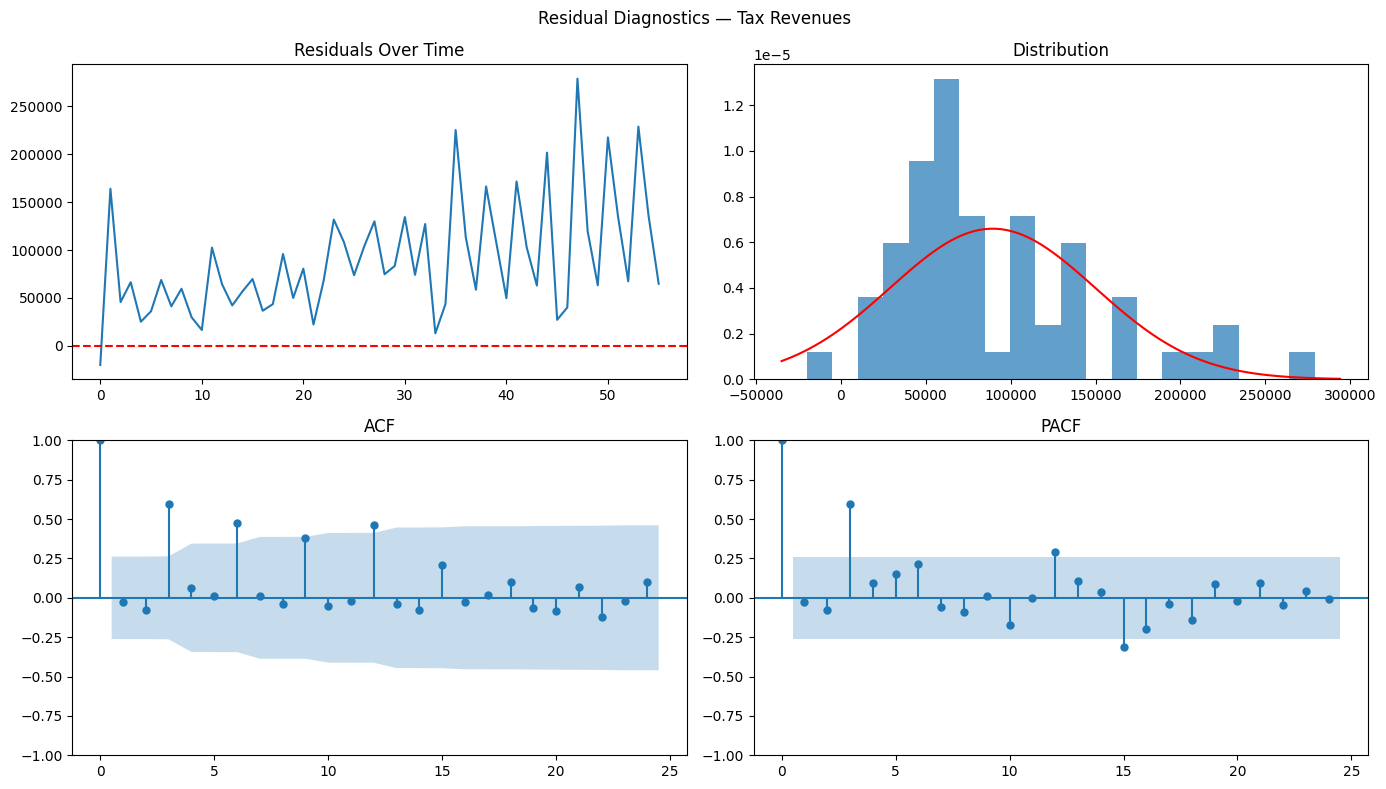

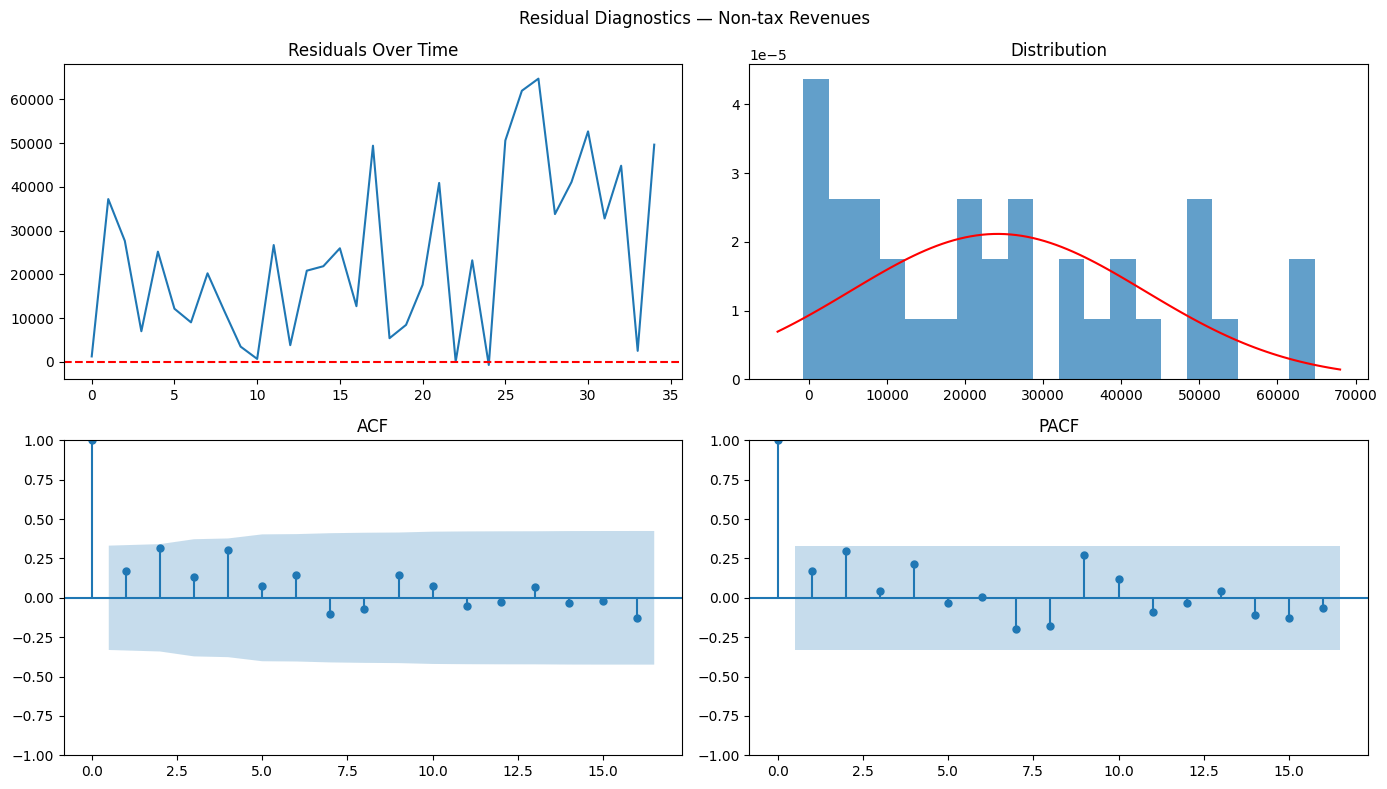

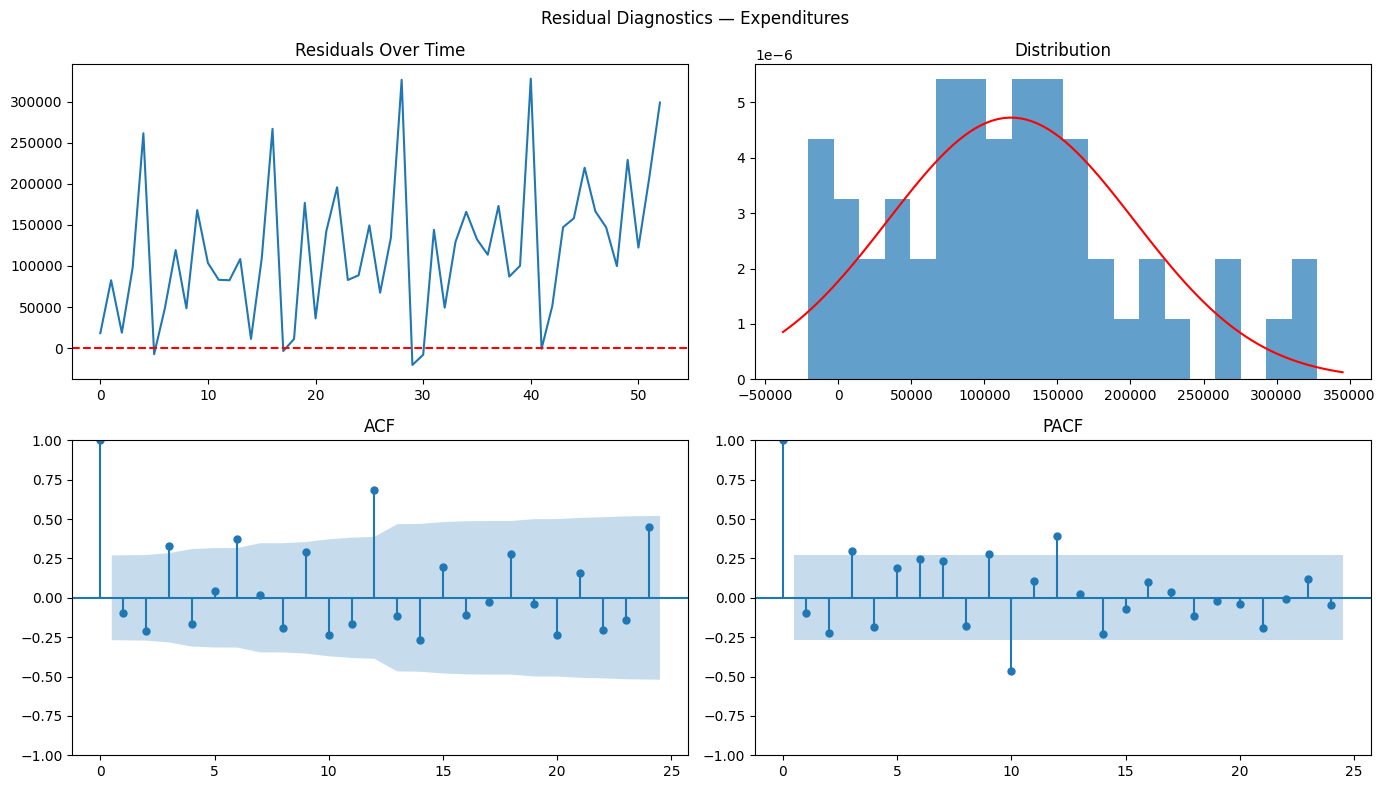

In [5]:
for label in LABEL_COLS:
    label_slug = label.replace(' ', '_')
    actual = np.load(f"results/{label_slug}/test_actuals.npy").flatten()
    preds  = np.load(f"results/{label_slug}/test_predictions.npy").flatten()
    utils.plot_residual_diagnostics(actual, preds, label, save_dir=f"results/{label_slug}")

## (S)ARIMA Fitting

In [6]:
LABEL_COLS = ['Tax Revenues', 'Non-tax Revenues', 'Expenditures']

SARIMA_GRID = {
    'p_range': range(0, 4),
    'd':       0,
    'q_range': range(0, 4),
    'top_n':   5,
}

sarima_summary = {}

for label in LABEL_COLS:
    label_slug = label.replace(' ', '_')
    print(f"\n{'='*60}\n  {label}\n{'='*60}")

    # Load residuals
    train_actuals   = np.load(f"results/{label_slug}/train_actuals.npy").flatten()
    train_preds_arr = np.load(f"results/{label_slug}/train_predictions.npy").flatten()
    val_actuals     = np.load(f"results/{label_slug}/val_actuals.npy").flatten()
    val_preds_arr   = np.load(f"results/{label_slug}/val_predictions.npy").flatten()
    test_actuals    = np.load(f"results/{label_slug}/test_actuals.npy").flatten()
    gru_preds       = np.load(f"results/{label_slug}/test_predictions.npy").flatten()

    train_residuals = train_actuals - train_preds_arr
    val_residuals   = val_actuals   - val_preds_arr
    fit_residuals   = np.concatenate([train_residuals, val_residuals])
    test_residuals  = test_actuals  - gru_preds

    # Grid search on train residuals, evaluate on val residuals
    print("\n  Grid search")
    best = sm.gridsearch(train=train_residuals, val=val_residuals, **SARIMA_GRID)
    print(f"\n  Top {SARIMA_GRID['top_n']} by MSE:")
    print(best.to_string(index=False))
    best.to_csv(f"results/{label_slug}/arima_grid_search.csv", index=False)

    # Final fit on train+val residuals, predict test residuals
    print("\n  Fitting best model")
    top = best.iloc[0]
    residual_preds, metrics, model = sm.fit_sarima(
        fit_residuals, test_residuals, top['order']
    )

    # Hybrid prediction
    hybrid_preds   = gru_preds + residual_preds
    hybrid_metrics = sm.compute_metrics(test_actuals, hybrid_preds)

    np.save(f"results/{label_slug}/arima_residual_predictions.npy", residual_preds)
    np.save(f"results/{label_slug}/hybrid_predictions.npy",         hybrid_preds)

    print(f"  ARIMA{tuple(top['order'])}")
    print(f"  Residual MSE  : {top['MSE']:.2f}")
    print(f"  GRU MAPE      : {sm.compute_metrics(test_actuals, gru_preds)['mape']:.4f}%")
    print(f"  Hybrid MAPE   : {hybrid_metrics['mape']:.4f}%")
    print(f"  Hybrid RMSE   : {hybrid_metrics['rmse']:.2f}")

    gru_metrics = sm.compute_metrics(test_actuals, gru_preds)
    sarima_summary[label] = {
        'order':       list(top['order']),
        'gru_mape':    float(gru_metrics['mape']),
        'gru_rmse':    float(gru_metrics['rmse']),
        'hybrid_mape': float(hybrid_metrics['mape']),
        'hybrid_rmse': float(hybrid_metrics['rmse']),
    }

with open("results/arima_summary.json", "w") as f:
    json.dump(sarima_summary, f, indent=4)

# ── Summary ───────────────────────────────────────────────
print(f"\n{'='*60}\nFINAL SUMMARY\n{'='*60}")
rows = []
for label, info in sarima_summary.items():
    rows.append({"Label": label, "Model": "GRU",    "MAPE": f"{info['gru_mape']:.4f}%",    "RMSE": f"{info['gru_rmse']:.2f}"})
    rows.append({"Label": label, "Model": "Hybrid", "MAPE": f"{info['hybrid_mape']:.4f}%", "RMSE": f"{info['hybrid_rmse']:.2f}"})

print(pd.DataFrame(rows).to_string(index=False))


  Tax Revenues

  Grid search
  Fitting 16 models...
    5/16 done...
    10/16 done...


c:\Anaconda\envs\capsenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


    15/16 done...

  Top 5 by MSE:
    order          MSE
(0, 0, 1) 2.207908e+09
(1, 0, 0) 2.252561e+09
(0, 0, 0) 2.265423e+09
(1, 0, 1) 2.338191e+09
(0, 0, 3) 2.690862e+09

  Fitting best model
  ARIMA(0, 0, 1)
  Residual MSE  : 2207907966.15
  GRU MAPE      : 17.2119%
  Hybrid MAPE   : 16.0937%
  Hybrid RMSE   : 76623.85

  Non-tax Revenues

  Grid search
  Fitting 16 models...
    5/16 done...
    10/16 done...


c:\Anaconda\envs\capsenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Anaconda\envs\capsenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Anaconda\envs\capsenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Anaconda\envs\capsenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Anaconda\envs\capsenv\Lib\site-packages\statsmodels\base\model

    15/16 done...

  Top 5 by MSE:
    order          MSE
(3, 0, 1) 3.120881e+08
(0, 0, 0) 3.134024e+08
(3, 0, 2) 3.138005e+08
(0, 0, 1) 3.163914e+08
(2, 0, 3) 3.167909e+08

  Fitting best model
  ARIMA(3, 0, 1)
  Residual MSE  : 312088102.58
  GRU MAPE      : 42.1365%
  Hybrid MAPE   : 41.4817%
  Hybrid RMSE   : 22484.34

  Expenditures

  Grid search
  Fitting 16 models...
    5/16 done...
    10/16 done...
    15/16 done...

  Top 5 by MSE:
    order          MSE
(3, 0, 2) 1.094799e+10
(0, 0, 0) 1.106450e+10
(3, 0, 1) 1.175948e+10
(1, 0, 0) 1.187838e+10
(2, 0, 1) 1.190793e+10

  Fitting best model
  ARIMA(3, 0, 2)
  Residual MSE  : 10947990126.45
  GRU MAPE      : 26.4807%
  Hybrid MAPE   : 13.7966%
  Hybrid RMSE   : 82082.19

FINAL SUMMARY
           Label  Model     MAPE      RMSE
    Tax Revenues    GRU 17.2119%  77777.89
    Tax Revenues Hybrid 16.0937%  76623.85
Non-tax Revenues    GRU 42.1365%  24105.35
Non-tax Revenues Hybrid 41.4817%  22484.34
    Expenditures    GRU 26.4807

c:\Anaconda\envs\capsenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Plots

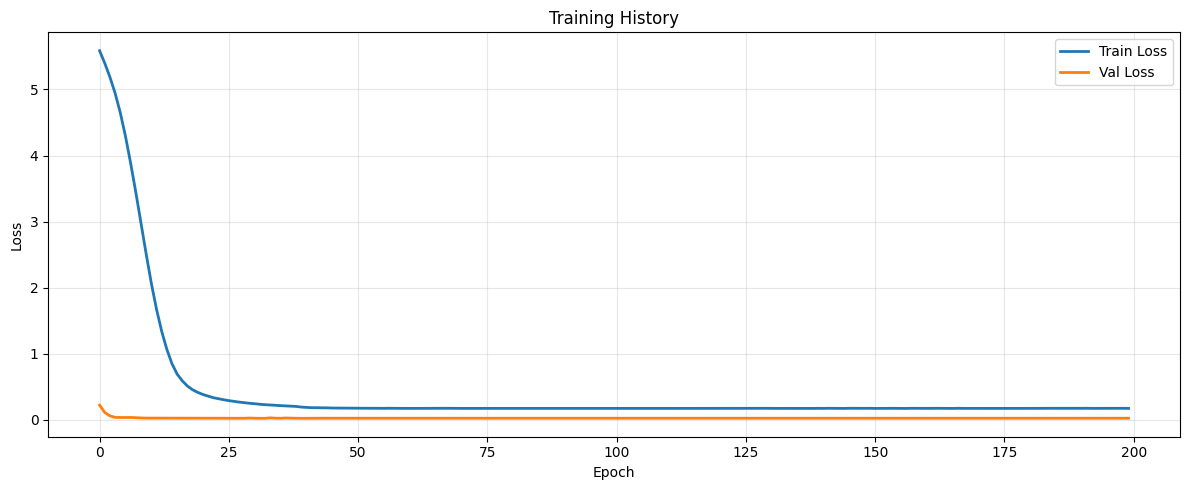

In [20]:
utils.plot_training_history(train_losses, val_losses)


  PLOTTING: disaggregated__num_lag_dummy_seasonal

Training History:


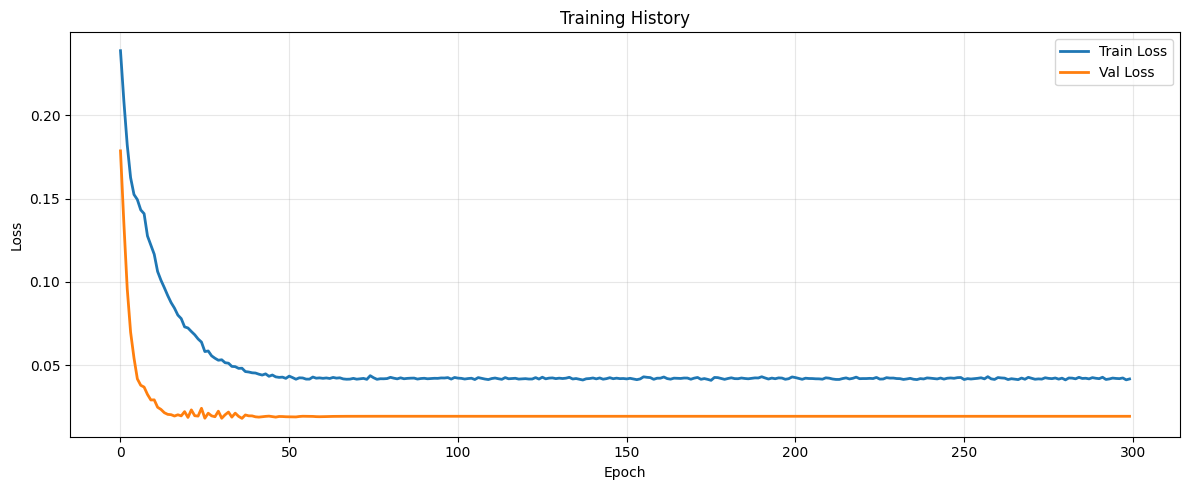


Test Predictions:


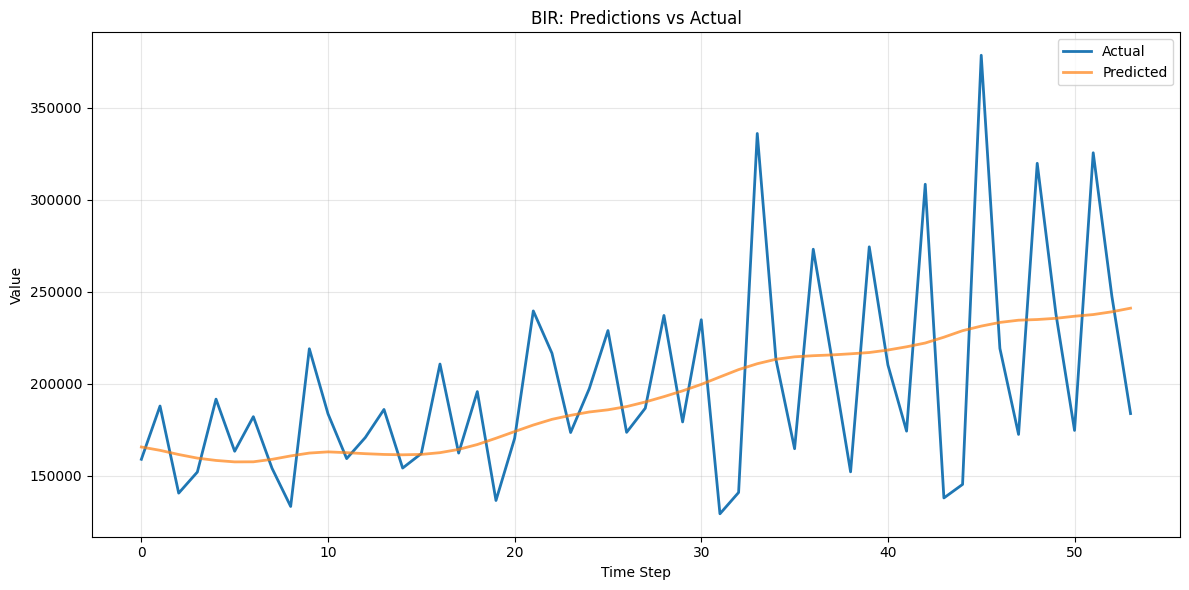

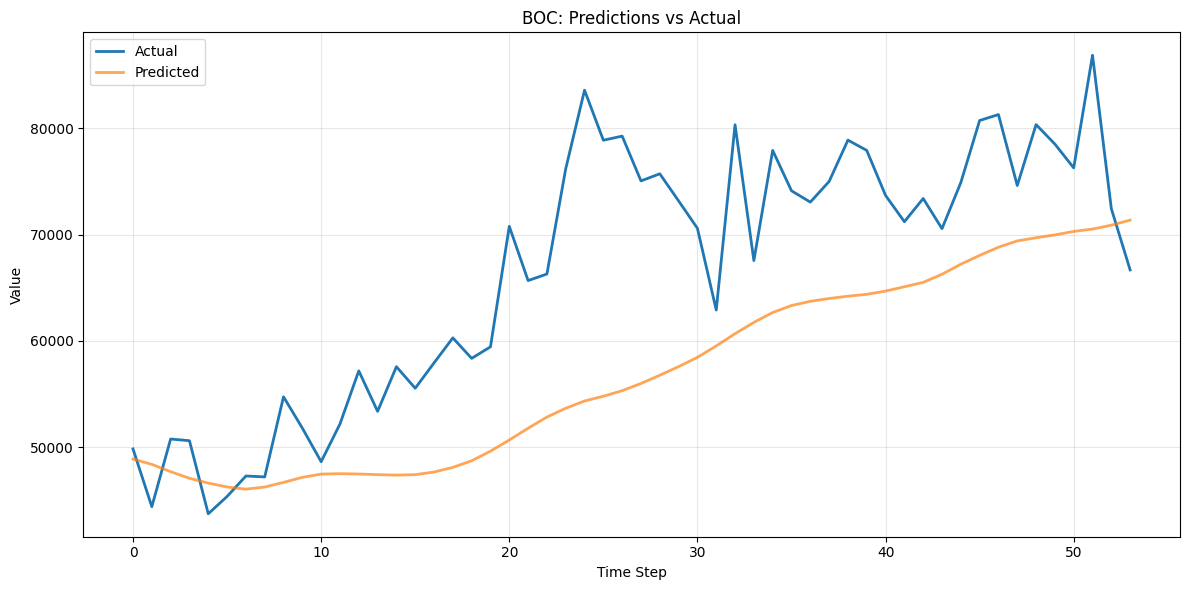

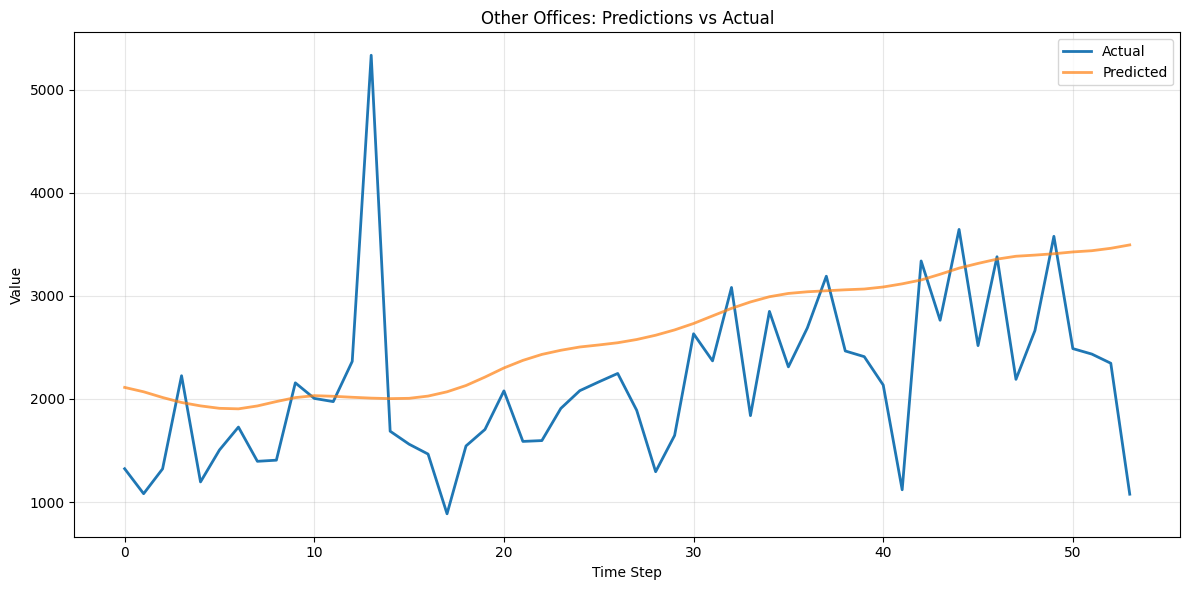

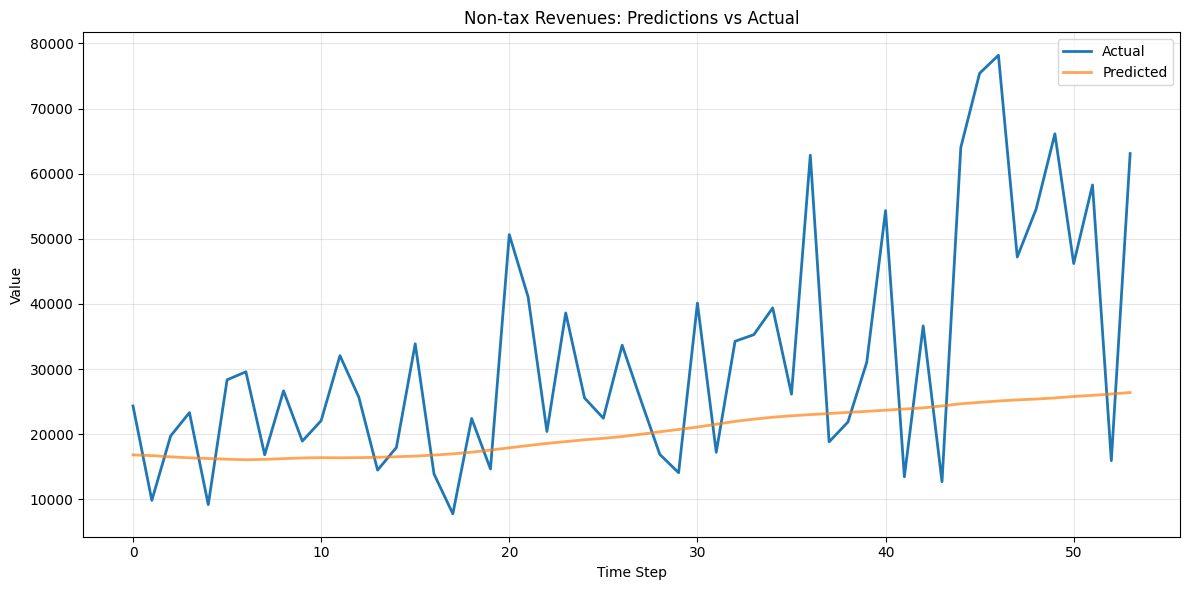

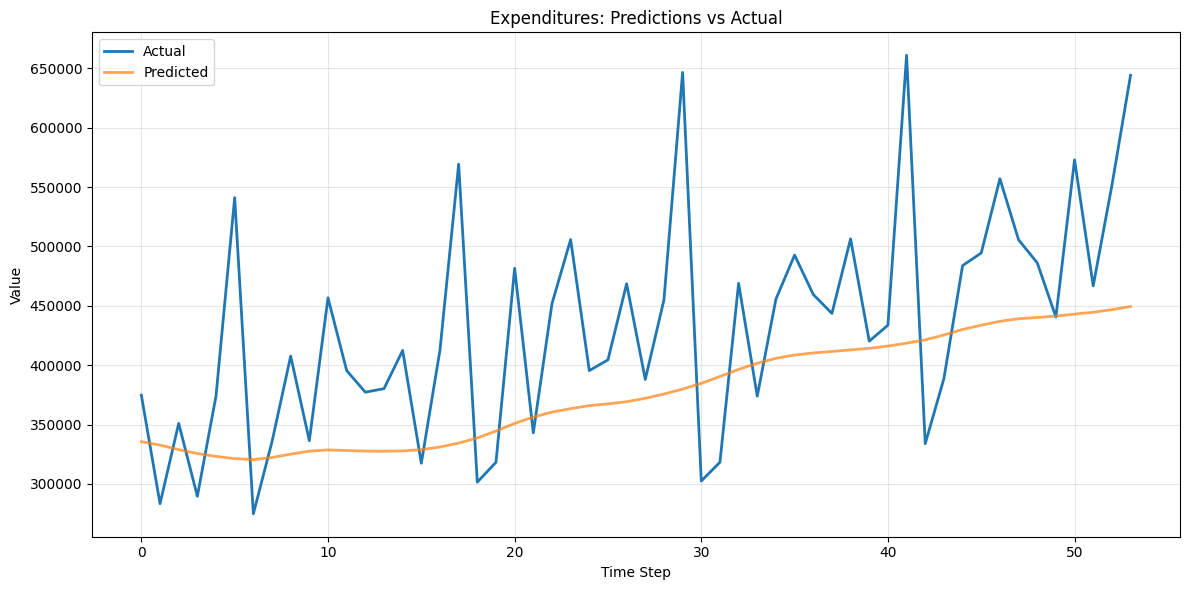

In [3]:
EXPERIMENTS_TO_PLOT = [
   # "aggregated__num_lag_dummy",
   # "aggregated__num_lag_covid",
    #"aggregated__num_lag_dummy_seasonal",
   # "aggregated__num_lag_covid_seasonal",
    #"disaggregated__num_lag_dummy",
    #"disaggregated__num_lag_covid",
    "disaggregated__num_lag_dummy_seasonal",
    #"disaggregated__num_lag_covid_seasonal",
]

for exp_name in EXPERIMENTS_TO_PLOT:
    results_folder = f"results/{exp_name}"
    config_folder = f"configs/{exp_name}"
    
    print(f"\n{'='*60}")
    print(f"  PLOTTING: {exp_name}")
    print(f"{'='*60}")
    
    # Load predictions and losses
    test_preds = np.load(f"{results_folder}/test_predictions.npy")
    train_losses = np.load(f"{results_folder}/train_losses.npy")
    val_losses = np.load(f"{results_folder}/val_losses.npy")
    
    # Load config to get args
    with open(f"{config_folder}/best_config.json", "r") as f:
        best_config = json.load(f)
    
    args = tr.Arguments(**best_config)
    
    # Reconstruct test_loader
    dataset = tr.load_dataset(args)
    final_test_scaled = transform_data(dataset['test_data'], f"Transforms/{exp_name}/test_scaled.pkl")
    final_test_labels_scaled = transform_data(dataset['test_labels'], f"Transforms/{exp_name}/labels_scaled.pkl")
    test_dataset = TimeSeriesDataset(final_test_scaled, final_test_labels_scaled, seq_len=args.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Plot training history
    print("\nTraining History:")
    utils.plot_training_history(train_losses, val_losses)
    
    # Plot predictions
    print("\nTest Predictions:")
    utils.plot_test_predictions(
        test_preds,
        test_loader,
        args,
        scaler_path=f"Transforms/{exp_name}/labels_scaled.pkl"
    )

# SHAP

temporary

not yet checked for correctness


  SHAP ANALYSIS: disaggregated__num_lag_dummy_seasonal


  0%|          | 0/20 [00:00<?, ?it/s]


SHAP Feature Importance (All Outputs):


d:\School\ADMU\M AMF\caps_git\utils.py:153: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values, test_data, feature_names=feature_names, show=False)
c:\Anaconda\envs\capsenv\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Anaconda\envs\capsenv\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Anaconda\envs\capsenv

<Figure size 1000x800 with 0 Axes>

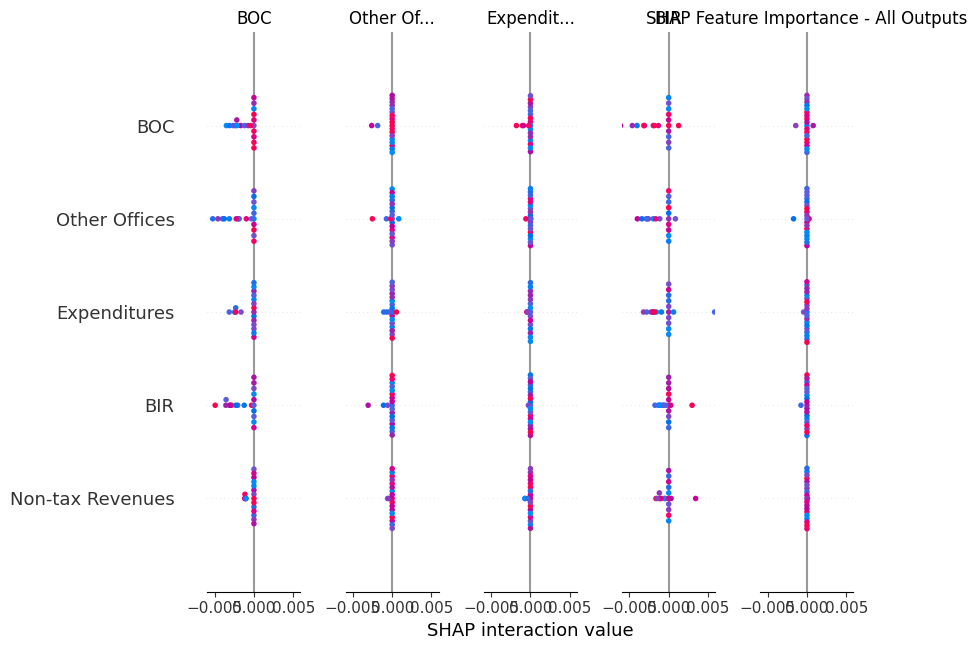


SHAP Mean Importance (All Outputs):


d:\School\ADMU\M AMF\caps_git\utils.py:176: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values, test_data, feature_names=feature_names, plot_type="bar", show=False)


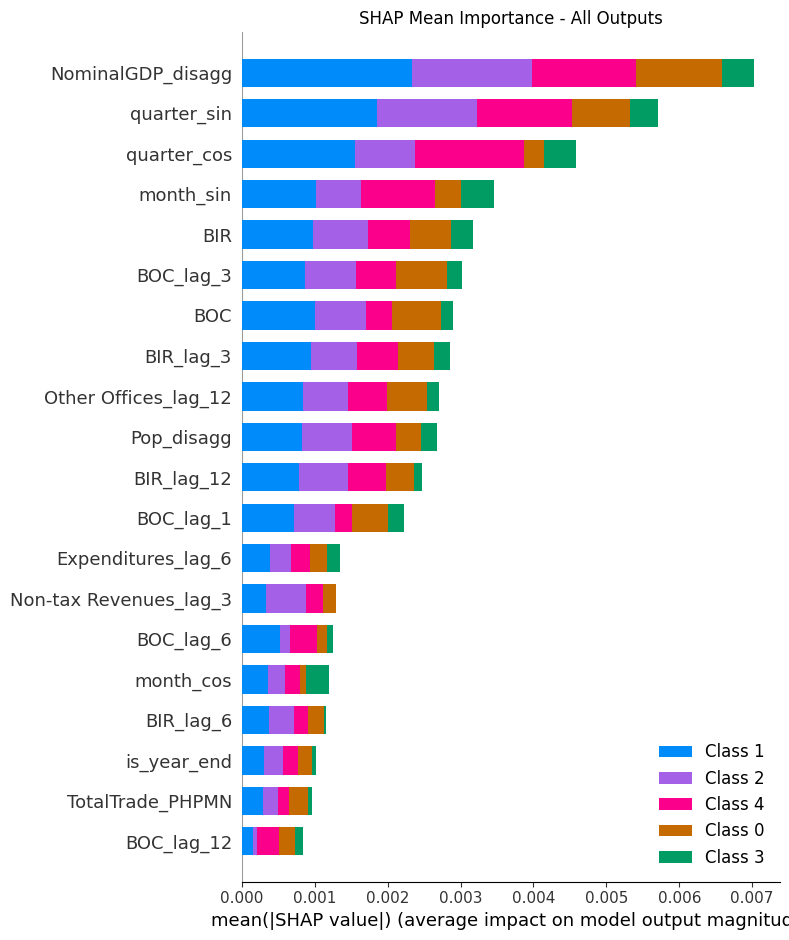


SHAP Waterfall for BIR:


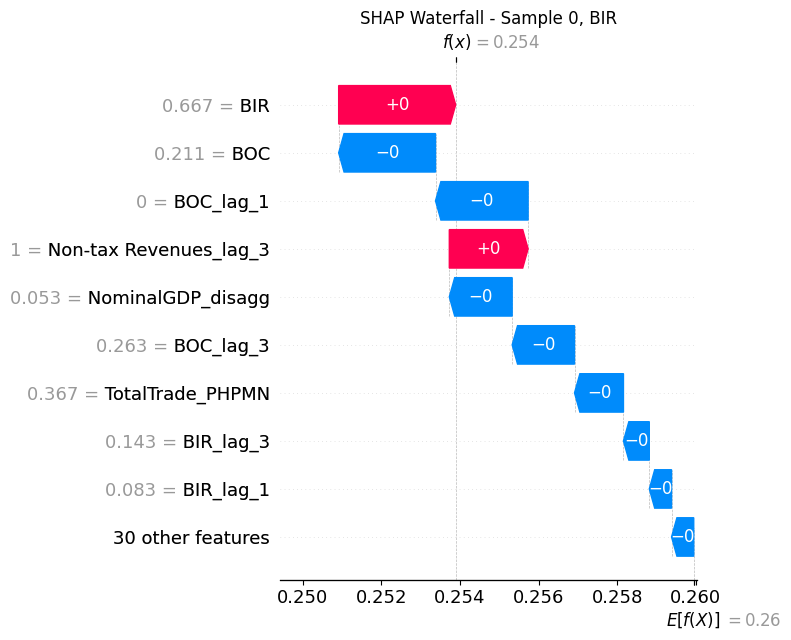


SHAP Waterfall for BOC:


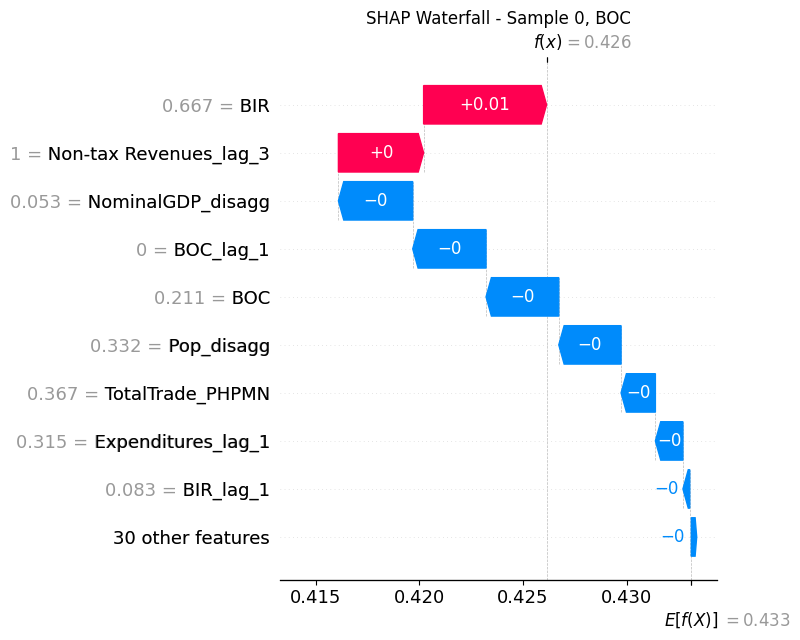


SHAP Waterfall for Other Offices:


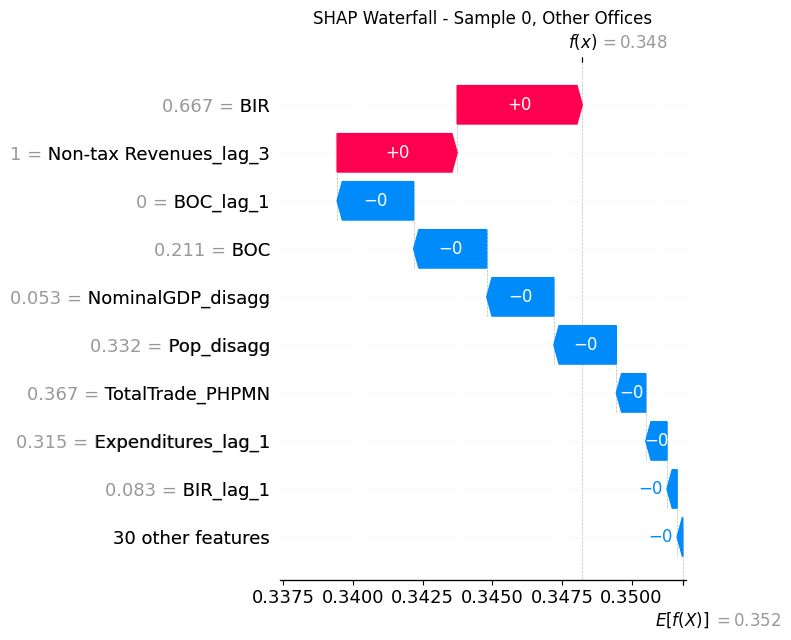


SHAP Waterfall for Non-tax Revenues:


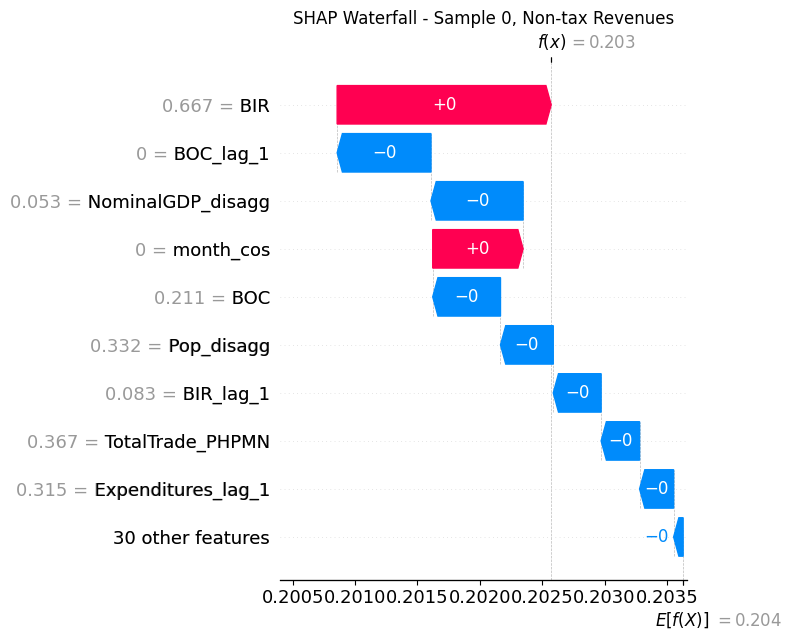


SHAP Waterfall for Expenditures:


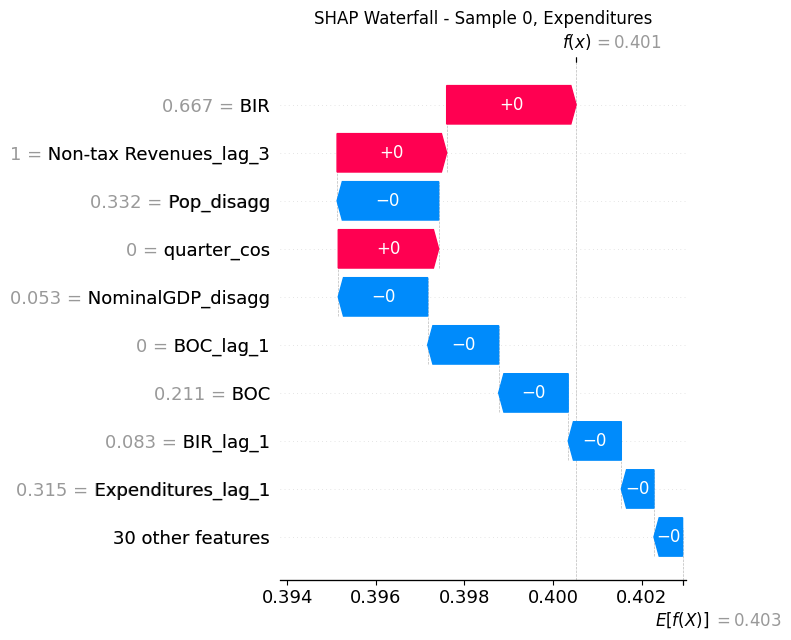

In [2]:
# ============================================================
# SHAP EXPLANATIONS 
# ============================================================

# Specify which experiments to explain
EXPERIMENTS_TO_EXPLAIN = [
    #"aggregated__num_lag_dummy",
    #"aggregated__num_lag_covid",
    #"aggregated__num_lag_dummy_seasonal",
    #"aggregated__num_lag_covid_seasonal",
    #"disaggregated__num_lag_dummy",
    #"disaggregated__num_lag_covid",
    "disaggregated__num_lag_dummy_seasonal",
    #"disaggregated__num_lag_covid_seasonal",
]



for exp_name in EXPERIMENTS_TO_EXPLAIN:
    results_folder = f"results/{exp_name}"
    config_folder = f"configs/{exp_name}"
    
    model_path = f"{results_folder}/final_model.pth"

    print(f"\n{'='*60}")
    print(f"  SHAP ANALYSIS: {exp_name}")
    print(f"{'='*60}")
    
    # Load config
    with open(f"{config_folder}/best_config.json", "r") as f:
        best_config = json.load(f)
    
    args = tr.Arguments(**best_config)
    
    # Set device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    args.device = device
    
    # Reconstruct dataset and test_loader
    dataset = tr.load_dataset(args)
    final_test_scaled = transform_data(dataset['test_data'], f"Transforms/{exp_name}/test_scaled.pkl")
    final_test_labels_scaled = transform_data(dataset['test_labels'], f"Transforms/{exp_name}/labels_scaled.pkl")
    test_dataset = TimeSeriesDataset(final_test_scaled, final_test_labels_scaled, seq_len=args.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Recreate and load model
    tr.set_seed(1)
    final_model = GRUModel(
        input_size=dataset['input_size'],
        hidden_size=args.hidden_size,
        output_size=dataset['output_size'],
        num_layers=args.num_layers,
        dropout=args.dropout,
        num_attention_heads=getattr(args, 'num_attention_heads', 4),
        args=args
    ).to(device)
    
    final_model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Generate SHAP explanations
    explainer, shap_values, test_data_shap, feature_names = utils.explain_model(
        final_model,
        test_loader,
        args,
        num_samples=50 
    )

    output_names = args.labels if hasattr(args, 'labels') else ['Output']

    print("\nSHAP Feature Importance (All Outputs):")
    utils.plot_shap_summary(shap_values, test_data_shap, feature_names, output_idx=0, output_name="All Outputs")

    print("\nSHAP Mean Importance (All Outputs):")
    utils.plot_shap_bar(shap_values, test_data_shap, feature_names, output_idx=0, output_name="All Outputs")

    for i, output_name in enumerate(output_names):
        print(f"\nSHAP Waterfall for {output_name}:")
        utils.plot_shap_waterfall(explainer, shap_values, test_data_shap, feature_names, sample_idx=0, output_idx=i, output_name=output_name)